# Deep Learning
## Summative assessment
### Coursework 2

#### Instructions

This coursework is released on **Wednesday 21st February 9.00** and is due by **Wednesday 6th March 23.59**. It is worth **40%** of your overall mark. There are 4 questions in this assessment, and a total of 100 marks are available. **You should attempt to answer all questions.** In addition to the total number of marks per question below, an additional 10 marks is available for presentation and clarity/quality of code.

This assessment assesses your ability to design, implement, train and evaluate a deep learning model for a classification task using multimodal data.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

#### Submission instructions

The submission for this assessment will consist of a notebook (.ipynb file) and a PDF submission.

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also submit a PDF copy of your executed notebook, in case the .ipynb file is corrupted for some reason. 

Upload a zip file containing your notebook and separate PDF file(s) to Coursera by the deadline above.

In [1]:
# You will need the following imports for this assessment. You can make additional imports when you need them

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow.keras.layers import (Layer, Input, Dense, GRU, Embedding, Conv2D, BatchNormalization, Activation, GlobalMaxPooling2D)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# You will need access to a GPU for this coursework

tf.config.list_physical_devices('GPU')

[]

#### The CLEVR Dataset

This assessment makes use of the [CLEVR Dataset](https://cs.stanford.edu/people/jcjohns/clevr/). This dataset is a visual question answering dataset, and consists of images with corresponding text questions and answers about the image.  

* Johnson, J., Hariharan, B., van der Maaten, L., Li, F.-F., Zitnick, C. L. & Girshick, R. (2016), "CLEVR: A Diagnostic Dataset for Compositional Language and Elementary Visual Reasoning", *IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*, 1988-1997.

The original dataset consists of a training set of 70,000 images and 699,989 questions, a validation set of 15,000 images and 149,991 questions, and a test set of 15,000 images and 14,988 questions. In this coursework you will work with a subset of the training and validation splits, which have been preprocessed and prepared for you. 

The data is stored in TFRecord format, which is a data format that is efficient for TensorFlow to work with. You can read about the TFRecord format [here](https://www.tensorflow.org/tutorials/load_data/tfrecord) if you are interested, but there is no need to find out about TFRecord for this assessment. The code to read in the TFRecord data to Dataset objects is provided for you below.

In [3]:
train_ds = tf.data.TFRecordDataset([os.path.join('data', 'train', f) 
                                    for f in os.listdir(os.path.join('data', 'train')) if f.endswith('tfrecords')])
val_ds = tf.data.TFRecordDataset([os.path.join('data', 'val', f) 
                                    for f in os.listdir(os.path.join('data', 'val')) if f.endswith('tfrecords')])

In [4]:
# The following helper function will parse the TFRecord files to return a dictionary of TensorFlow objects

def parse_function(example_proto):
    features = {
        "image": tf.io.FixedLenFeature((), tf.string),
        "question": tf.io.VarLenFeature(dtype=tf.string),
        "answer": tf.io.VarLenFeature(dtype=tf.string)
    }
    parsed_features = tf.io.parse_single_example(serialized=example_proto, features=features)
    parsed_features["question"] = tf.sparse.to_dense(parsed_features["question"])
    parsed_features["answer"] = tf.sparse.to_dense(parsed_features["answer"])
    image = tf.io.decode_raw(parsed_features["image"], tf.int32)
    image = tf.reshape(image, [224, 224, 3])
    parsed_features["image"] = image
    return parsed_features

In [5]:
train_ds = train_ds.map(parse_function)
val_ds = val_ds.map(parse_function)

In [6]:
train_ds.element_spec

{'answer': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'question': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'image': TensorSpec(shape=(224, 224, 3), dtype=tf.int32, name=None)}

Your task in this assessment is to develop a deep learning model to predict the answer for a given question about an image.

You will need to implement special customised layers and a sophisticated model architecture, making use of both CNN and RNN models. You will process the data, train and evaluate the specified model, and then write a proposal for your own modified architecture.

### Question 1 (Total 15 marks)

The training and validation datasets both return dictionaries with keys `"image"`, `"question"` and `"answer"`. For each image, there are multiple questions and answers. The question and answer entries in the dictionary are both lists of strings of the same length, with aligned questions and answers for the given image. The image entry is a 224x224x3 integer Tensor. These images have been resized from the original size of 480x320, so they appear slightly stretched (this can be ignored). 

a) Inspect the contents of the dataset by displaying at least one image and it's corresponding questions and answers.

**(3 marks)**

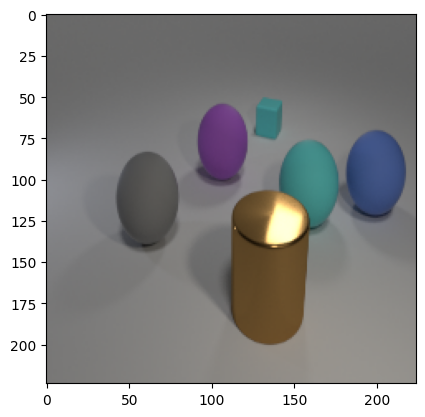

Question: b'There is a purple object that is the same size as the blue matte sphere; what is its shape?'
Answer: b'sphere'
Question: b'What number of other things are there of the same color as the cube?'
Answer: b'1'
Question: b'What is the color of the object that is in front of the big gray rubber ball?'
Answer: b'brown'
Question: b'How many other things are there of the same material as the gray thing?'
Answer: b'4'
Question: b'Are there more big brown objects right of the gray thing than tiny things in front of the big cyan thing?'
Answer: b'yes'
Question: b'What number of things are on the left side of the brown metallic cylinder?'
Answer: b'2'
Question: b'Is the large blue thing made of the same material as the large thing that is in front of the large gray rubber object?'
Answer: b'no'
Question: b'Are there any other things that have the same shape as the small matte object?'
Answer: b'no'
Question: b'Do the cube and the brown cylinder have the same material?'
Answer: b'no'
Que

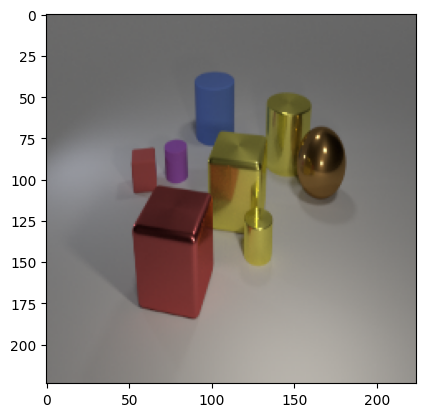

Question: b'Do the tiny shiny cylinder and the big shiny cylinder have the same color?'
Answer: b'yes'
Question: b'There is a purple cylinder that is made of the same material as the tiny block; what is its size?'
Answer: b'small'
Question: b'What is the color of the large object that is both right of the yellow shiny cube and behind the brown metallic thing?'
Answer: b'yellow'
Question: b'How many blue matte cylinders are the same size as the shiny ball?'
Answer: b'1'
Question: b'What is the size of the other metallic cylinder that is the same color as the big shiny cylinder?'
Answer: b'small'
Question: b'There is a cube that is both on the right side of the small red thing and to the left of the blue rubber object; how big is it?'
Answer: b'large'
Question: b'There is a small rubber thing behind the small thing left of the small purple rubber object; what number of yellow shiny objects are on the left side of it?'
Answer: b'0'
Question: b'Are there any small metallic cylinders of the

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Assuming 'train_ds' is already defined and is a tf.data.Dataset object
for example in train_ds.take(2):
    image = example['image'].numpy()
    questions = example['question'].numpy()
    answers = example['answer'].numpy()

    # Display the image
    plt.imshow(image)
    plt.show()

    # Print the questions and answers
    for question, answer in zip(questions, answers):
        print('Question:', question)
        print('Answer:', answer)

b) The training and validation Datasets should be processed as follows:

* The image pixel values should be scaled to the interval $[0, 1]$.
* The answers should be (sparse) encoded as integer labels. You will need to compute the total number of distinct answers to do this.
* The questions should be tokenized and represented as a sequence of integer tokens. The questions should be split on whitespace and standardized by lowercasing and removing punctuation. 
* A single question-answer pair should be uniformly sampled from the available questions and answers for each image (so each image should appear exactly once per epoch with a single question-answer pair).
* The inputs to the model will be the question and the image. The targets will be the answer. Process the Datasets so that they return a tuple of 2 elements corresponding to inputs and targets.
* Shuffle the training Dataset, and batch both Datasets with batch size 64.

Print out the number of distinct answer labels, as well as the number of tokens in the vocabulary computed from the questions.

Print out the element_spec of one of the Datasets after processing. 

**(12 marks)**

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Assuming `parse_function` is defined as in your provided code snippet.

# Helper function to scale images
def scale_images(features):
    features['image'] = tf.cast(features['image'], tf.float32) / 255.0
    return features

# Function to tokenize questions
def tokenize_questions(questions, vocab_size=10000, output_sequence_length=20):
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode='int',
        output_sequence_length=output_sequence_length)
    
    vectorize_layer.adapt(questions)
    return vectorize_layer, vectorize_layer.get_vocabulary()

# Function to prepare datasets
def prepare_dataset(dataset, vectorize_layer, answer_to_index, is_training=True):
    def sample_and_process(features):
        features = scale_images(features)
        idx = tf.random.uniform(shape=[], maxval=tf.shape(features['question'])[0], dtype=tf.int32)
        question = tf.gather(features['question'], idx)
        answer = tf.gather(features['answer'], idx)
        
        question = vectorize_layer(question)
        answer = answer_to_index.lookup(answer)
        
        inputs = {'image': features['image'], 'question': question}
        return inputs, answer
    
    dataset = dataset.map(sample_and_process)
    if is_training:
        dataset = dataset.shuffle(1000)
    dataset = dataset.batch(64)
    return dataset

# Collect all questions and answers to build vocabularies
all_questions = []
all_answers = set()
for features in train_ds.concatenate(val_ds):
    all_questions.extend([q.numpy().decode('utf-8') for q in features['question']])
    all_answers.update([a.numpy().decode('utf-8') for a in features['answer']])

# Tokenize questions and create a question vocabulary
vectorize_layer, question_vocab = tokenize_questions(all_questions)

# Create a mapping for answers to integers
answers = list(all_answers)
answer_to_index = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=answers,
        values=tf.range(len(answers), dtype=tf.int64)),
    default_value=-1)

# Prepare datasets
train_ds = prepare_dataset(train_ds, vectorize_layer, answer_to_index, is_training=True)
val_ds = prepare_dataset(val_ds, vectorize_layer, answer_to_index, is_training=False)

print(f"Number of distinct answer labels: {len(answers)}")
print(f"Number of tokens in the question vocabulary: {len(question_vocab)}")

# Print the element_spec of the training dataset
print(train_ds.element_spec)

Number of distinct answer labels: 28
Number of tokens in the question vocabulary: 82
({'image': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), 'question': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))


### Question 2 (Total 35 marks)

The model that you will implement for the visual question answering task was first proposed in the paper

* Perez, E., Strub, F., de Vries, H. & Courville, A. (2018), "FiLM: visual reasoning with a general conditioning layer", in _Proceedings of the Thirty-Second AAAI Conference on Artificial Intelligence_, New Orleans, Louisiana, USA.

The main idea is the introduction of a specialised layer called a FiLM layer (Feature-wise Linear Modulation). The purpose of this layer is to modify the predictions that are made by a CNN prediction model (the central stack coloured in brown in the figure below). The CNN prediction model takes the image as input, and outputs a categorical distribution over the set of possible answers.

The FiLM layer uses information stored in a vector embedding (which comes from the question text) to modify the post-activations of the CNN prediction model. This vector embedding is produced by a gated recurrent unit (GRU) network (referred to in the original paper as the FiLM generator) as the final hidden layer representation after processing the input question. This vector embedding is also referred to as the conditioning signal.

The overall model architecture is shown in the figure below:

![image](figures/model.png)

The question is tokenized, and learned embeddings are processed sequentially by the GRU network/FiLM generator. There are potentially multiple FiLM layers within the CNN prediction model. Each FiLM layer uses the GRU embedding $\mathbf{q}$ (the conditioning signal) to modify the output of a convolutional layer within the CNN prediction model, as described in part c).

a) Implement the FiLM generator as a 2-layer stacked GRU network, using an embedding dimension of 64, and 128 neurons for both of the layers of the GRU. The network should output the final 128-dimensional embedding. Print the model summary.

**(3 marks)**

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

# Assuming max_length is the maximum length of the questions and vocab_size is the size of the vocabulary
max_length = 100  # Example value, adjust as per your dataset
vocab_size = 82  # Example value, adjust as per your dataset
def film_generator(vocab_size, embed_dim=64, gru_units=128, input_size = (None,)):
    inputs = tf.keras.Input(shape=input_size, dtype=tf.int32)
    x= tf.keras.layers.Embedding(vocab_size, embed_dim)(inputs)
    x = tf.keras.layers.GRU(gru_units, return_sequences=True)(x)
    x = tf.keras.layers.GRU(gru_units)(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

film_gen = film_generator(vocab_size)
film_gen.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 64)          5248      
                                                                 
 gru (GRU)                   (None, None, 128)         74496     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
Total params: 178816 (698.50 KB)
Trainable params: 178816 (698.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


b) The first block of the CNN prediction model is a feature extractor CNN which does not make use of the conditioning signal $\mathbf{q}$ from the GRU network. This block takes the image as input, and passes it through two sub-blocks, each consisting of the following layers:

* A 2D convolutional layer with 128 filters, a 4x4 kernel, 2x2 strides, 'SAME' padding, and no activation function
* A batch normalisation layer
* An element-wise ReLU activation

Implement the feature extractor CNN and print the model summary.

**(2 marks)**

In [11]:
# Define the feature extractor CNN
def feature_extractor_cnn(input_shape=(224, 224, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

feature_extractor = feature_extractor_cnn()
print(feature_extractor.summary())


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     6144      
                                                                 
 batch_normalization_2 (Bat  (None, 112, 112, 128)     512       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 112, 112, 128)     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 128)       262144    
                                                                 
 batch_normalization_3 (Bat  (None, 56, 56, 128)       512       
 chNormalization)                                          

c) Implement a custom layer class for the FiLM layer as described below. This class should subclass the base `Layer` class in the `tensorflow.keras.layers` module. 

This layer will need to take two inputs when it is called: the conditioning signal $\mathbf{q}$, as well as the previous convolutional layer output $\mathbf{h}$. 

The FiLM layer passes the conditioning signal $\mathbf{q}$ output by the GRU FiLM generator through a linear layer (dense layer with no activation function) to produce $\gamma$ and $\beta$:

$$
\gamma = \textrm{Linear}(\mathbf{q}) \quad\quad \beta = \textrm{Linear}(\mathbf{q}).
$$

Both $\gamma$ and $\beta$ are vectors, with length equal to the number of feature maps (or channels) in the output of a convolutional layer $\mathbf{h}$. These post-activations are then modulated via the feature-wise affine transformation:

$$
\textrm{FiLM}(\mathbf{h} | \gamma, \beta)_{h, w, c} = \gamma_c \mathbf{h}_{h, w, c} + \beta_c,
$$
where the subscripts $h, w, c$ index the height, width and channel dimensions respectively.

Create an instance of your custom layer class and test it on some dummy inputs to verify it works as expected.

**(10 marks)**

In [12]:
class FiLMLayer(Layer):
    def __init__(self,**kwargs):
        super(FiLMLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape[0] is the shape of the conditioning signal
        # input_shape[1] is the shape of the convolutional layer output
        channels = input_shape[1][-1]
        self.dense_gamma = Dense(channels,use_bias=False)
        self.dense_beta = Dense(channels,use_bias=False)

    def call(self, inputs):
        # Unpack the inputs. Expect inputs to be a list: [conditioning_signal, convolution_output]
        conditioning_signal, conv_output = inputs
        
        # Generate gamma and beta from the conditioning signal
        gamma = self.dense_gamma(conditioning_signal)
        beta = self.dense_beta(conditioning_signal)
        
        # Apply the FiLM operation: for each channel, multiply by gamma and add beta
        # tf.reshape is used to ensure gamma and beta are broadcast correctly over the H and W dimensions.
        gamma = tf.expand_dims(tf.expand_dims(gamma, 1), 1)
        beta = tf.expand_dims(tf.expand_dims(beta, 1), 1)
        
        # Perform the feature-wise affine transformation
        return gamma * conv_output + beta

cs_dimension = 128
conv_shape = (None, 56, 56, 128)  # Example shape

# Create dummy data to test the FiLM layer
batch_size = 10
dum_conv_output = tf.random.normal((batch_size, cs_dimension))
dum_conditioning_signal = tf.random.normal((batch_size,) + conv_shape[1:])

# Create an instance of the FiLM layer
film_layer = FiLMLayer()

# Test the custom layer
film_output = film_layer([dum_conv_output, dum_conditioning_signal])
print(f"input shapes: {dum_conv_output.shape}, {dum_conditioning_signal.shape}")
print(f"output shape: {film_output.shape}")

input shapes: (10, 128), (10, 56, 56, 128)
output shape: (10, 56, 56, 128)


d) The second main block of the CNN network consists of a number of ResBlocks. Each ResBlock consists of the following layers:

![image](figures/resblock.png)


* A 1x1 convolutional layer with 128 channels and ReLU activation function
* A 3x3 convolutional layer with 128 channels and no activation function
* A BatchNormalization layer, where the usual $\gamma$ and $\beta$ parameters are not used
* a FiLM layer, that also uses the conditioning signal $\mathbf{q}$ from the GRU network
* An elementwise ReLU activation function
* The output is then added to the output of the first convolutional layer

Each convolutional layer uses 'SAME' padding.

Implement the ResBlock as another custom layer. Similar to the FiLM layer, this layer will also need to take two inputs when it is called: the conditioning signal $\mathbf{q}$, as well as the previous convolutional layer output $\mathbf{h}$. 

Create an instance of your custom layer class and test it on some dummy inputs to verify it works as expected.

**(8 marks)**

In [13]:
class ResBlock(tf.keras.layers.Layer):
    def __init__(self, channels=128, **kwargs):
        super(ResBlock, self).__init__(**kwargs)
        self.channels = channels

    def build(self, input_shape):
        # Define the 1x1 convolutional layer with ReLU activation
        self.conv1 = tf.keras.layers.Conv2D(self.channels, kernel_size=(1, 1), padding='SAME', activation='relu')
        # Define the 3x3 convolutional layer with no activation
        self.conv2 = tf.keras.layers.Conv2D(self.channels, kernel_size=(3, 3), padding='SAME')
        # BatchNormalization layer without γ and β, which will be provided by the FiLM layer
        self.batch_normalization = tf.keras.layers.BatchNormalization(scale=False, center=False)
        # Initialize the FiLM layer
        self.film_layer = FiLMLayer()

    def call(self, inputs):
        # Unpack the inputs, conditioning signal q and previous conv layer output h
        conditioning_signal, conv_output = inputs
        
        # Apply 1x1 conv with ReLU activation
        conv1_output = self.conv1(conv_output)
        
        # Apply 3x3 conv without activation
        conv2_output = self.conv2(conv1_output)
        
        # Apply batch normalization
        bn_output = self.batch_normalization(conv2_output)
        
        # Apply FiLM layer using the conditioning signal q and the output of the batch normalization
        film_output = self.film_layer([conditioning_signal, bn_output])
        
        # Apply ReLU activation function
        relu_output = tf.nn.relu(film_output)
        
        # Elementwise addition with the output of the first convolutional layer
        res_output = relu_output + conv1_output
        
        return res_output


In [14]:
dummy_conv_input = tf.random.normal((batch_size, cs_dimension))
dummy_conditioning_signal = tf.random.normal((batch_size,) + conv_shape[1:])

# Create an instance of the ResBlock layer
resblock_layer = ResBlock()

# Test the custom layer
resblock_output = resblock_layer([dummy_conv_input, dummy_conditioning_signal])
print(f"ResBlock input shape: {dummy_conv_input.shape}")
print(f"ResBlock output shape: {resblock_output.shape}")

ResBlock input shape: (10, 128)
ResBlock output shape: (10, 56, 56, 128)


e) At several points in the model, two coordinate feature maps will be added to the output of a convolutional layer. This operation will be applied before each ResBlock and the classifier component of the CNN prediction model. 

These two feature maps indicate relative $x$ and $y$ spatial position, and are each scaled from $-1$ to $1$ across the height and width dimensions. These two feature maps are concatenated as two extra channels to the convolutional layer output.

Implement this operation as another custom layer class called `AddSpatialCoordinates`. The layer should be able to accept input Tensors with arbitrary height, width and channel dimensions. This custom layer will not have any trainable variables.

Create an instance of your custom layer class and test it on some dummy inputs to verify it works as expected.

**(7 marks)**

In [15]:
class AddSpatialCoordinates(Layer):
    def __init__(self, **kwargs):
        super(AddSpatialCoordinates, self).__init__(**kwargs)
    
    def call(self, input_tensor):
        # Get the dynamic shape of the input tensor
        batch_size, height, width, channels = tf.shape(input_tensor)[0], tf.shape(input_tensor)[1], tf.shape(input_tensor)[2], tf.shape(input_tensor)[3]
        
        # Create coordinate feature maps for x and y
        x_map = tf.linspace(-1.0, 1.0, width)
        y_map = tf.linspace(-1.0, 1.0, height)
        
        # Tile and expand dimensions to match input_tensor shape
        x_map = tf.tile(x_map[tf.newaxis, tf.newaxis, :, tf.newaxis], [batch_size, height, 1, 1])
        y_map = tf.tile(y_map[tf.newaxis, :, tf.newaxis, tf.newaxis], [batch_size, 1, width, 1])
        
        # Concatenate the coordinate feature maps to the input tensor
        output_tensor = tf.concat([input_tensor, x_map, y_map], axis=-1)
        return output_tensor

    def compute_output_shape(self, input_shape):
        # Output shape will have two more channels than the input shape
        return (input_shape[0], input_shape[1], input_shape[2], input_shape[3] + 2)

In [16]:
# Example to test AddSpatialCoordinates
batch_size = 10
height, width, channels = 56, 56, 128  # Example dimensions for the input tensor

# Create dummy inputs
dummy_input = tf.random.normal((batch_size, height, width, channels), dtype=tf.float32)

# Create an instance of the AddSpatialCoordinates layer
add_spatial_coordinates_layer = AddSpatialCoordinates()

# Apply the layer to the dummy inputs
output_with_coords = add_spatial_coordinates_layer(dummy_input)

print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output_with_coords.shape}")

Input shape: (10, 56, 56, 128)
Output shape: (10, 56, 56, 130)


f) The final main block of the CNN network is a classifier block. This block consists of the following layers:

* 1x1 convolution with 512 output channels, ReLU activation, and 'SAME' padding
* Global max pooling across height and width dimensions
* Dense layer with 512 neurons and ReLU activation
* Final Dense layer with $n_c$ neurons and softmax activation, where $n_c$ is the number of output labels

Once you have implemented the classifier, you should bring all components together to build the complete model. This model consists of the following:

* GRU FiLM generator as defined in part a) that processes the sequence of question tokens and outputs an embedding $\mathbf{q}$ of dimension 128
* Feature extractor block as defined in part b) that processes the input image
* The output of the feature extractor should then be extended with spatial coordinate feature maps by passing it through your `AddSpatialCoordinates` layer
* This should be followed by just one ResBlock custom layer, that takes in two inputs: the output from the previous `AddSpatialCoordinates` layer and the question embedding $\mathbf{q}$. We will only use one ResBlock due to computational limitations
* The output of the ResBlock should then also be extended with spatial coordinate feature maps by passing it through your `AddSpatialCoordinates` layer
* The output from the previous `AddSpatialCoordinates` layer should then be sent through the classifier block to obtain the final output prediction

Implement the complete model according to the above spec, and print the model summary.

**(5 marks)**

In [17]:
class ClassifierBlock(Layer):
    def __init__(self, n_classes, **kwargs):
        super(ClassifierBlock, self).__init__(**kwargs)
        self.n_classes = n_classes

    def build(self, input_shape):
        # Define the 1x1 convolutional layer with ReLU activation
        self.conv1 = tf.keras.layers.Conv2D(512, kernel_size=(1, 1), padding='SAME', activation='relu')
        # GlobalMaxPooling2D layer
        self.global_max_pooling = tf.keras.layers.GlobalMaxPooling2D()
        # Dense layer with ReLU activation
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        # Dense layer with softmax activation
        self.dense2 = tf.keras.layers.Dense(self.n_classes, activation='softmax')

    def call(self, inputs):
        # Apply 1x1 conv with ReLU activation
        conv1_output = self.conv1(inputs)
        # Apply global max pooling
        global_max_pooling_output = self.global_max_pooling(conv1_output)
        # Apply first dense layer
        dense1_output = self.dense1(global_max_pooling_output)
        # Apply second dense layer
        output = self.dense2(dense1_output)
        return output

In [18]:
# Instantiate the layers and blocks
vocab_size = len(question_vocab)  # Replace with the actual size of your question vocabulary
gru_film_generator = film_generator(vocab_size=vocab_size)
feature_extractor = feature_extractor_cnn(input_shape=(224, 224, 3))
add_spatial_coordinates_layer1 = AddSpatialCoordinates()
resblock_layer = ResBlock()
add_spatial_coordinates_layer2 = AddSpatialCoordinates()

# Assume num_classes is the number of distinct answer labels in your dataset
num_classes = len(answers)  # Replace with the actual number
classifier_block = ClassifierBlock(n_classes=num_classes)

# Define the functional model
def model(question_vocab_size, image_shape=(224, 224, 3), num_classes=num_classes):
    # Inputs with specified names that match the dataset keys
    image_input = tf.keras.Input(shape=image_shape, name='image')
    question_input = tf.keras.Input(shape=(None,), dtype=tf.int32, name='question')

    # GRU FiLM generator
    embedding = gru_film_generator(question_input)

    # Feature extractor CNN
    cnn_features = feature_extractor(image_input)

    # Add spatial coordinates
    cnn_features_with_coords = add_spatial_coordinates_layer1(cnn_features)

    # ResBlock with FiLM
    resblock_output = resblock_layer([embedding, cnn_features_with_coords])

    # Add spatial coordinates again
    resblock_output_with_coords = add_spatial_coordinates_layer2(resblock_output)

    # Classifier block
    predictions = classifier_block(resblock_output_with_coords)

    # Build the model
    model = tf.keras.Model(inputs=[image_input, question_input], outputs=predictions)

    return model

# Build and summarize the complete model
complete_model = model(question_vocab_size=vocab_size, num_classes=num_classes)
complete_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 question (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 model_4 (Functional)        (None, 56, 56, 128)          269312    ['image[0][0]']               
                                                                                                  
 model_3 (Functional)        (None, 128)                  178816    ['question[0][0]']            
                                                                                            

### Question 3 (Total 30 marks)

a) You should now train your model from question 2 using a cross entropy loss function. Train the model for 20 epochs, with an Adam optimizer with learning rate 3e-4. You should track model performance on the validation set, including the accuracy. 

Your code should be structured to account for restarting broken training runs. You will need to save your model every epoch, and save all of the model's training and validation performance up to that point (a convenient method is to use the `CSVLogger` callback). In the case of a broken training run, the required data should be loaded, and the training run resumed from the last saved checkpoint. You do not need to use early stopping in the training run.

When training has completed, compute and print the final evaluation of your model on the validation set.

_NB: The model would need to be larger and trained for longer to achieve good performance on this task. The model and training have been scaled down to accommodate infrastructure limitations on the Coursera platform. You should implement the architecture as specified in this assessment, but you can train the model for longer if you wish. The performance of the resulting model is **not** part of the marking criteria._

**(15 marks)**

In [19]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam

# Define paths for the checkpoint and logs
checkpoint_path = "data/amber_model_checkpoint.h5"  # Replace with your desired checkpoint path
log_path = "data/amber_training_log.csv"  # Replace with your desired log path

# Compile the model
complete_model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if your labels are integers
    metrics=['accuracy']
)

In [20]:
# Callback for saving the model after each epoch
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False
)

In [21]:
# Callback for logging the training history
csv_logger = CSVLogger(log_path, append=True)

# Check if there is a previous checkpoint to resume training
if os.path.exists(checkpoint_path):
    print("Checkpoint found, loading weights.")
    complete_model.load_weights(checkpoint_path)

# Check if there is a previous log to resume logging
if not os.path.exists(log_path):
    # Create a new CSVLogger if no log exists
    csv_logger = CSVLogger(log_path, append=False)
else:
    # Append to the existing log
    csv_logger = CSVLogger(log_path, append=True)

In [22]:
# Train the model
history = complete_model.fit(
    train_ds,  # Assuming train_ds is correctly formatted
    epochs=20,
    validation_data=val_ds,  # Assuming val_ds is correctly formatted
    callbacks=[model_checkpoint_callback, csv_logger]
)

# Evaluate the model on the validation set
final_evaluation = complete_model.evaluate(val_ds)  # Replace with your validation dataset
print("Final evaluation on the validation set:", final_evaluation)


Epoch 1/20
234/234 [==============================] - 886s 4s/step - loss: 2.2865 - accuracy: 0.2412 - val_loss: 2.1574 - val_accuracy: 0.3187
Epoch 2/20
234/234 [==============================] - 2364s 10s/step - loss: 1.6255 - accuracy: 0.3367 - val_loss: 1.5893 - val_accuracy: 0.3693
Epoch 3/20
234/234 [==============================] - 837s 4s/step - loss: 1.4138 - accuracy: 0.3715 - val_loss: 1.3336 - val_accuracy: 0.4013
Epoch 4/20
234/234 [==============================] - 835s 4s/step - loss: 1.2624 - accuracy: 0.3891 - val_loss: 1.2535 - val_accuracy: 0.4093
Epoch 5/20
234/234 [==============================] - 843s 4s/step - loss: 1.2184 - accuracy: 0.4056 - val_loss: 1.1682 - val_accuracy: 0.4320
Epoch 6/20
234/234 [==============================] - 828s 4s/step - loss: 1.1953 - accuracy: 0.4083 - val_loss: 1.1830 - val_accuracy: 0.4227
Epoch 7/20
234/234 [==============================] - 832s 4s/step - loss: 1.1672 - accuracy: 0.4153 - val_loss: 1.1763 - val_accuracy: 0.41

b) Plot the loss and accuracy over the course of training on the training and validation sets.

Select at least one sample image and question from the validation set, and compute the model predictions. Display the image, question, ground truth answer and model predictive distribution over the set of answers.

**(7 marks)**

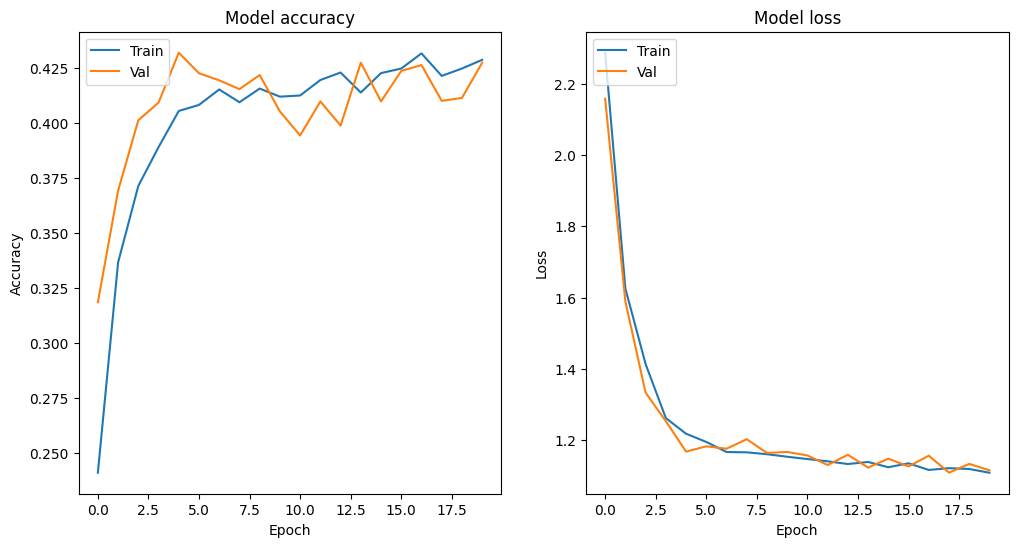

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

2/2 [==============================] - 1s 324ms/step


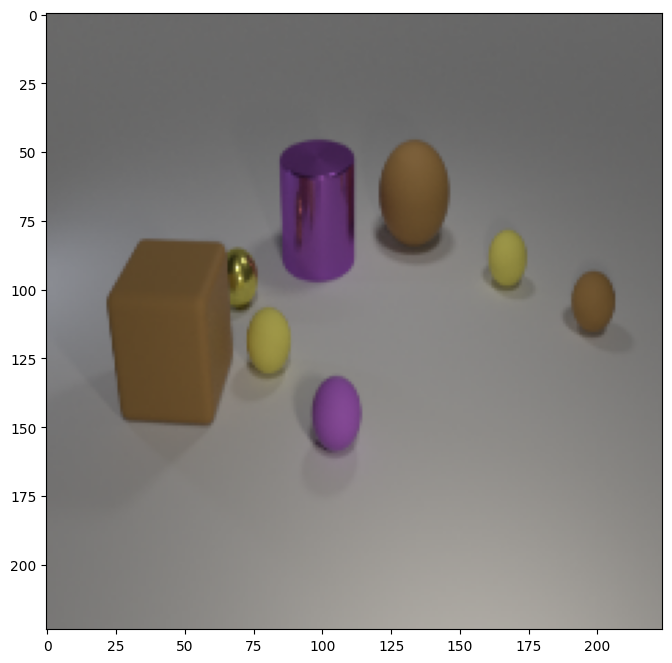

Question: what number of objects are either brown things right of the big metallic object or yellow spheres
Ground Truth Answer: 5
Predicted Answer: 1
Predictive Distribution: [1.8381536e-02 3.4279183e-05 7.6503470e-03 2.1362925e-05 2.2804086e-05
 2.8711779e-03 2.6506132e-05 1.1764394e-01 3.5443260e-05 4.2275157e-02
 4.5752957e-05 1.5580874e-03 2.3068604e-05 3.0737218e-01 2.2479229e-05
 1.2928473e-05 1.4280357e-05 4.1650637e-05 6.7004359e-05 1.6343733e-02
 1.7677449e-01 1.7364904e-05 1.9896641e-05 4.9854989e-05 2.8971789e-02
 2.7963471e-01 3.1911728e-05 3.6260630e-05]
2/2 [==============================] - 1s 322ms/step


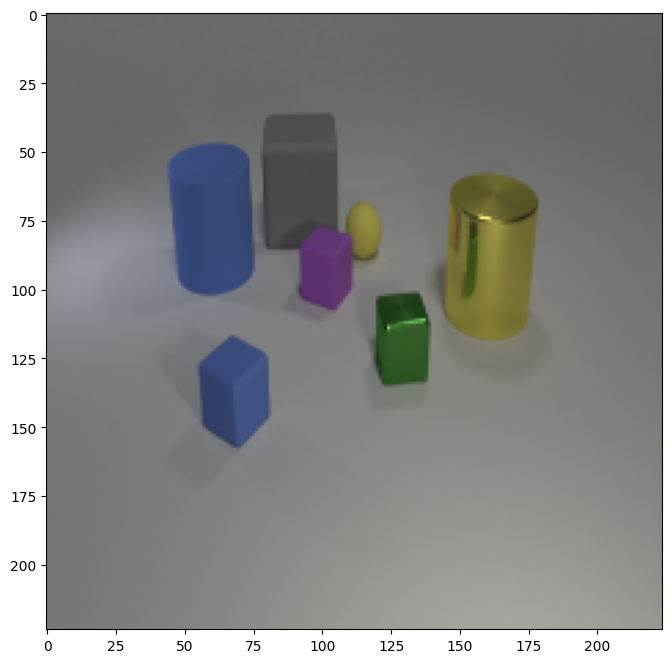

Question: how many purple objects have the same material as the green object
Ground Truth Answer: 0
Predicted Answer: 0
Predictive Distribution: [4.3656746e-01 5.7315421e-05 3.9530746e-04 6.6592649e-05 4.1218624e-05
 6.8874469e-05 4.1861098e-05 1.3133083e-02 3.2058192e-04 4.0970258e-03
 3.4067204e-04 1.5720782e-04 6.2179475e-05 3.6506575e-01 3.9255581e-05
 2.3972209e-05 4.8902228e-05 3.1780590e-05 3.0815337e-04 1.0150573e-03
 2.9762236e-02 2.9464789e-05 3.3497661e-05 6.6514447e-05 2.2459442e-03
 1.4562522e-01 2.4742406e-04 1.0742881e-04]


In [28]:
import numpy as np
import tensorflow as tf

# Assuming you have a way to decode the question and answer tokens
# These functions should be adjusted according to your actual tokenization scheme
def decode_question(pred, ans):
    pred_idx = np.argmax(pred)
    return ans[pred_idx]

def display_answer(ans, sample, model):
    (iandq, ans_idx) = sample
    image = iandq['image'][0]
    question = iandq['question'][0]
    
    # Predict
    pred = model.predict(iandq)
    pred_ans = decode_question(pred[0], ans)
    
    # Decode the question and answer
    true_ans = ans[ans_idx.numpy()[0]]
    
    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.show()
    
    q = vectorize_layer.get_vocabulary()
    q_tokens = [q[i] for i in question if i != 0]
    q_text = ' '.join(q_tokens)
    
    print(f"Question: {q_text}")
    print(f"Ground Truth Answer: {true_ans}")
    print(f"Predicted Answer: {pred_ans}")
    print(f"Predictive Distribution: {pred[0]}")
    

tf.random.set_seed(1883471)

# Select a sample from the validation dataset
for sample in val_ds.take(2):
    display_answer(answers, sample, complete_model)

c) Explain why adding spatial coordinate feature maps as in 2e) is beneficial for the proposed model and task from questions 1 and 2.

**(3 marks)**

Adding spatial coordinate feature maps as described in 2e) is beneficial for the proposed model and task for several reasons:

1. **Contextual Awareness**: Including spatial coordinates provides the model with information about the position of features within the input space. This is especially useful for tasks that are sensitive to the location of objects or patterns within an image. By knowing where a feature is located, the model can make more informed predictions.

2. **Improved Localization**: For tasks that involve object detection, segmentation, or any form of spatial localization, having explicit spatial coordinates helps the model to better understand and predict the location of objects. 
   
3. **Translation Invariance and Sensitivity**: While CNNs are naturally translation invariant to some degree, they may struggle with tasks that require understanding the absolute position of features within an image. By adding spatial coordinates, the model can be made sensitive to the absolute position of features, which is crucial for tasks where the spatial relationship between features affects the output.

4. **Enhanced Feature Representation**: The addition of coordinate feature maps increases the richness of the feature representation. This can be particularly beneficial in deeper layers of the model where the abstraction level is high, and the direct spatial information from the input image is lost. By reintroducing spatial information at various points in the model, it helps in maintaining a connection to the original spatial structure of the input.

5. **No Need for Trainable Parameters**: Since the spatial coordinate maps are generated based on the input dimensions and are not trainable, they add valuable information without increasing the complexity of the model or the need for additional training. This makes the feature both efficient and effective.

d) An alternative method to FiLM to incorporate conditioning information would be to concatenate the conditional embedding $\mathbf{q}$ with the channel dimension in a convolutional layer input $\mathbf{h}^{(k-1)}$ at every spatial location (in other words, concatenate constant feature maps with the input $\mathbf{h}^{(k-1)}$ to a convolutional layer). 

Explain how this method would compare in terms of computation and parameter efficiency with applying the FiLM layer computation outlined in 2c) to the output $\mathbf{h}^{(k)}$ of the convolutional layer. You can assume the convolutional layer has no activation function.

**(5 marks)**

The alternative method of concatenating the conditioning information $ \mathbf{q} $ with the convolutional layer input $ \mathbf{h}^{(k-1)} $ at every spatial location contrasts with FiLM in several ways as below:

### Concatenation Method:

- **Computational Complexity**: Concatenation increases the number of feature maps fed into the subsequent convolutional layers, thereby increasing the computational load. If $ \mathbf{q} $ is concatenated to $\mathbf{h}^{(k-1)} $ at every spatial location, the convolutional filters in the following layer have to process a larger number of input channels.
  
- **Parameter Efficiency**: This approach generally reduces parameter efficiency. The subsequent convolutional layer's weight matrix dimensions increase proportionally to the length of $ \mathbf{q}$, as each additional channel from the concatenation requires its own set of filter weights. This results in a significant increase in the number of parameters.

### FiLM Layer Method:

- **Computational Complexity**: FiLM modulates the feature maps after the convolution operation by applying a simple element-wise affine transformation. This operation has a minimal computational footprint compared to the cost of convolution operations.
  
- **Parameter Efficiency**: FiLM is more parameter-efficient, as it only adds two parameters per feature map $ \gamma $ and $\beta $, regardless of the size of $ \mathbf{q} $. It doesn't increase the number of filters or the depth of the weight matrix in the convolutional layers.

### Comparison:

- **Computational Load**: FiLM is computationally lighter because it doesn't change the input dimensionality for convolutions, unlike concatenation, which can significantly increase the computational burden.

- **Memory Footprint**: FiLM requires less memory for additional parameters, making it more efficient, especially when dealing with deep networks and high-dimensional embeddings.

- **Flexibility**: FiLM provides a more flexible approach to feature modulation as it allows for a more dynamic and fine-grained control of feature maps post-convolution, while concatenation is a static operation that doesn't allow for such control.

In conclusion, while concatenation is a straightforward method to include conditioning information, FiLM layers tend to be more computationally and parameter efficient, especially when dealing with large-scale and deep neural network architectures. This efficiency can be crucial when scaling up models for complex tasks or deploying them in resource-constrained environments.

### Question 4 (Total 10 marks)

Provide a separate PDF report with your evaluation and conclusions on the model and training results in this assessment.

In addition, compare the experiment conducted in this assessment with that described in section 2 of the [original paper](https://arxiv.org/abs/1709.07871). In particular, discuss how the model architecture and training algorithm differ.

Your report should be no more than 1 page.

**(10 marks)**